## File: onet_task_adjacency.ipynb
#### Summary: Explores ONET data to motivate th Agentic AI model

#### By: Peyman Shahidi
#### Created: Jan 15, 2025

<br>

In [1]:
#Python
import getpass
import numpy as np
import pandas as pd
from collections import defaultdict
import itertools
import random 

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [2]:
main_folder_path = ".."
input_data_path = f"{main_folder_path}/data"
output_data_path = f'{input_data_path}/computed_objects'
output_plot_path = f"{main_folder_path}/writeup/plots"

In [3]:
# Create directories if they don't exist
import os

for path in [output_data_path, output_plot_path]:
    if not os.path.exists(path):
        os.makedirs(path)

### Main Code Starts Here

<br>

## Section (1)

In [4]:
# Read O*NET data
onet = pd.read_csv(f'{input_data_path}/onet_occupations_yearly.csv')

# keep 2023 entries only
onet = onet[onet['year'] == 2023].reset_index(drop=True)

# keep occupation, task, work activity, and detailed work activity columns
onet = onet[['occ_code', 'occ_title', 'task_id', 'task', 'wa_id', 'wa_name', 'dwa_id', 'dwa_title']]
onet = onet.sort_values(by=['occ_code', 'task_id', 'wa_id', 'dwa_id']).reset_index(drop=True)

# remove 's for consistency issues 
onet = onet.applymap(lambda x: x.replace("'", "") if isinstance(x, str) else x)

In [5]:
# Print ONET stats
print(f"Number of unique occupation-task pairs in ONET data: {len(onet)}\n")

print(f'Number of unique occupations in ONET data: {len(onet["occ_title"].unique())}\n')

print(f'Number of unique tasks in ONET data: {len(onet["task_id"].unique())}')
print(f'Number of unique work activities in ONET data: {len(onet["wa_id"].unique())}')
print(f'Number of unique detailed work activities in ONET data: {len(onet["dwa_id"].unique())}')

Number of unique occupation-task pairs in ONET data: 24426

Number of unique occupations in ONET data: 798

Number of unique tasks in ONET data: 19294
Number of unique work activities in ONET data: 38
Number of unique detailed work activities in ONET data: 2086


### Remove "Teachers"-related occupations

In [6]:
# Filter rows that contain "Teacher" (case-insensitive)
contains_teacher = onet[onet['occ_title'].str.contains('Teachers', case=False, na=False)]

# Step 2: Get the number of unique occupations containing "Teacher"
unique_teacher_occupations = contains_teacher['occ_title'].nunique()
print(f'Number of unique occupations containing the word "Teachers": {unique_teacher_occupations}')

# Remove rows that contain "Teacher" (case-insensitive)
onet = onet[~onet['occ_title'].str.contains('Teachers', case=False, na=False)].reset_index(drop=True)

Number of unique occupations containing the word "Teachers": 50


In [7]:
# Print ONET stats after removing teachers
print('Stats after removing teachers:')
print(f"Number of unique occupation-task pairs in ONET data: {len(onet)}\n")

print(f'Number of unique occupations in ONET data: {len(onet["occ_title"].unique())}\n')

print(f'Number of unique tasks in ONET data: {len(onet["task_id"].unique())}')
print(f'Number of unique work activities in ONET data: {len(onet["wa_id"].unique())}')
print(f'Number of unique detailed work activities in ONET data: {len(onet["dwa_id"].unique())}')

Stats after removing teachers:
Number of unique occupation-task pairs in ONET data: 22650

Number of unique occupations in ONET data: 748

Number of unique tasks in ONET data: 17945
Number of unique work activities in ONET data: 38
Number of unique detailed work activities in ONET data: 2081


In [8]:
# Variables to work with
task_variable = 'dwa_title'
occupation_variable = 'occ_title'

# Remove duplicates in terms of occupation-task pairs
onet = onet.drop_duplicates(subset=[occupation_variable, task_variable])

# Other data cleanins
onet.replace("NaN", np.nan, inplace=True)
onet.dropna(how='any', inplace=True)

# print stats
print(f"Number of unique occupation-task pairs in ONET data: {len(onet)}\n")

# average number of tasks per occupation
grouped_counts = onet.groupby(occupation_variable)[task_variable].count()
overall_avg = grouped_counts.mean()

print(f"Average number of tasks for ONET occupation: {np.round(overall_avg)}\n")

Number of unique occupation-task pairs in ONET data: 15645

Average number of tasks for ONET occupation: 21.0



### Randomly assign tasks to occupations (note that each occupation gets assigned the same number of tasks it had in the original dataset)

In [9]:
random.seed(123)

# Get unique tasks
unique_tasks = onet[task_variable].unique().tolist()

# Count the number of tasks for each occupation
occupation_task_counts = onet.groupby(occupation_variable).size()

# Prepare a list for the new dataset
randomized_data = []

# Assign tasks randomly for each occupation
for occupation, task_count in occupation_task_counts.items():
    # Shuffle tasks and pick the required number of tasks
    assigned_tasks = random.sample(unique_tasks, task_count)
    # Add entries to the new dataset
    for task in assigned_tasks:
        randomized_data.append({occupation_variable: occupation, task_variable: task})

# Create the new DataFrame
onet_random_tasks = pd.DataFrame(randomized_data)

# Save the new DataFrame
onet_random_tasks.to_csv(f'{output_data_path}/onet_random_tasks.csv', index=False)

### Create task-task co-occurrence matrix

In [10]:
def create_task_task_cooc_matrix(df, 
                                 occupation_variable,
                                 task_variable):

    # Keep only the relevant columns
    df = df[[task_variable, occupation_variable]].dropna(subset=[task_variable, occupation_variable])

    # Rename for consistency
    df = df.rename(columns={task_variable: 'task',
                            occupation_variable: 'occupation'})

    # 1. Get unique tasks
    unique_tasks = df['task'].unique()
    
    # 2. Map each task to the set of occupations that have that task
    task_to_occupations = defaultdict(set)
    for row in df.itertuples(index=False):
        task_to_occupations[row.task].add(row.occupation)
    
    # 3. Prepare an empty DataFrame for the output matrix
    cooc_matrix = pd.DataFrame(
        index=unique_tasks, 
        columns=unique_tasks, 
        dtype=float
    )
    
    # 4. Calculate ratio for each pair (t1, t2)
    for t1 in unique_tasks:
        occ_set_t1 = task_to_occupations[t1]
        for t2 in unique_tasks:
            occ_set_t2 = task_to_occupations[t2]

            # Intersection: occupations containing both t1 and t2
            intersection = occ_set_t1.intersection(occ_set_t2)
            
            # Denominator: number of unique occupations containing either t1 or t2
            denom = len(occ_set_t1) + len(occ_set_t2) - len(intersection)

            # Handle zero-denominator case
            ratio = 0.0 if denom == 0 else len(intersection) / denom
            
            cooc_matrix.at[t1, t2] = ratio
    
    return cooc_matrix


# Get co-occurrence matrix
cooccurrence_matrix = create_task_task_cooc_matrix(onet, occupation_variable, task_variable) # in dataframe format
cooccurrence_matrix_random = create_task_task_cooc_matrix(onet_random_tasks, occupation_variable, task_variable) # in dataframe format

# Save co-occurrence matrix
cooccurrence_matrix.to_csv(f'{output_data_path}/task_task_cooccurrence_matrix.csv', index=True)

#### Get individual task co-occurrence score

In [11]:
def get_task_scores(cooccurrence_matrix):
    # Step 1: Calculate the average score of each row excluding the diagonal
    average_scores = []
    for task in cooccurrence_matrix.index:
        row = cooccurrence_matrix.loc[task]
        non_diagonal_values = row[row.index != task]  # Exclude the diagonal element
        average_scores.append({task_variable: task, 'cooccurrence_score': non_diagonal_values.mean()})

    # Step 2: Create the resulting DataFrame
    task_scores_df = pd.DataFrame(average_scores)
    task_scores_df = task_scores_df.sort_values(by='cooccurrence_score', ascending=False).reset_index(drop=True)

    return task_scores_df

# Get task scores
task_scores_df = get_task_scores(cooccurrence_matrix)
task_scores_df_random = get_task_scores(cooccurrence_matrix_random)

# Save the resulring dataframe to a CSV file
task_scores_df.to_csv(f'{output_data_path}/indiv_task_cooccurrence_scores.csv', header=False)

#### Get occupation co-occurrence scores

In [12]:
def compute_cooccurrence_scores(df, cooccurrence_matrix, occupation_variable, task_variable):

    # 1. Create a mapping of occupation -> set/list of tasks
    occ_to_tasks = df.groupby(occupation_variable)[task_variable].unique().to_dict()

    # 2. For each occupation, subset the co-occurrence matrix and compute the score
    cooccurrence_scores = {}
    for occ, tasks in occ_to_tasks.items():
        tasks = list(tasks)  # Ensure it's a list (instead of a numpy array)

        # Subset the co-occurrence matrix for tasks in this occupation.
        # Only include tasks that actually appear in cooccurrence_matrix's index (and columns).
        valid_tasks = [t for t in tasks if t in cooccurrence_matrix.index]
        if len(valid_tasks) < 2:
            # If only 0 or 1 tasks are present, the off-diagonal sum is trivially 0
            cooccurrence_scores[occ] = 0.0
            continue

        submatrix = cooccurrence_matrix.loc[valid_tasks, valid_tasks]

        # 3. Sum of all elements in the submatrix
        total_sum = submatrix.values.sum()

        # 4. Subtract the diagonal to get only off-diagonal elements
        diag_sum = np.trace(submatrix.values)
        off_diag_sum = total_sum - diag_sum

        # 5. Since the matrix is symmetric, each pair (i, j) is counted twice in off_diag_sum
        cooccurrence_score = off_diag_sum / 2 / (len(valid_tasks) * (len(valid_tasks) - 1))

        # Store the score
        cooccurrence_scores[occ] = cooccurrence_score

    # Create dataframe from the scores
    occupation_scores_df = pd.DataFrame(cooccurrence_scores.items(), columns=[occupation_variable, 'cooccurrence_score'])
    occupation_scores_df = occupation_scores_df.sort_values(by=['cooccurrence_score'], ascending=False).reset_index(drop=True)

    return occupation_scores_df


# Compute co-occurrence scores for each occupation
occupation_scores_df = compute_cooccurrence_scores(onet, cooccurrence_matrix, occupation_variable, task_variable)
occupation_scores_df_random = compute_cooccurrence_scores(onet_random_tasks, cooccurrence_matrix_random, occupation_variable, task_variable)

# Save the dataframe to a CSV file
occupation_scores_df.to_csv(f'{output_data_path}/indiv_occupation_cooccurrence_scores.csv', index=False)

### Plot individual occupation co-occurrence score and individual task co-occurrence score histograms

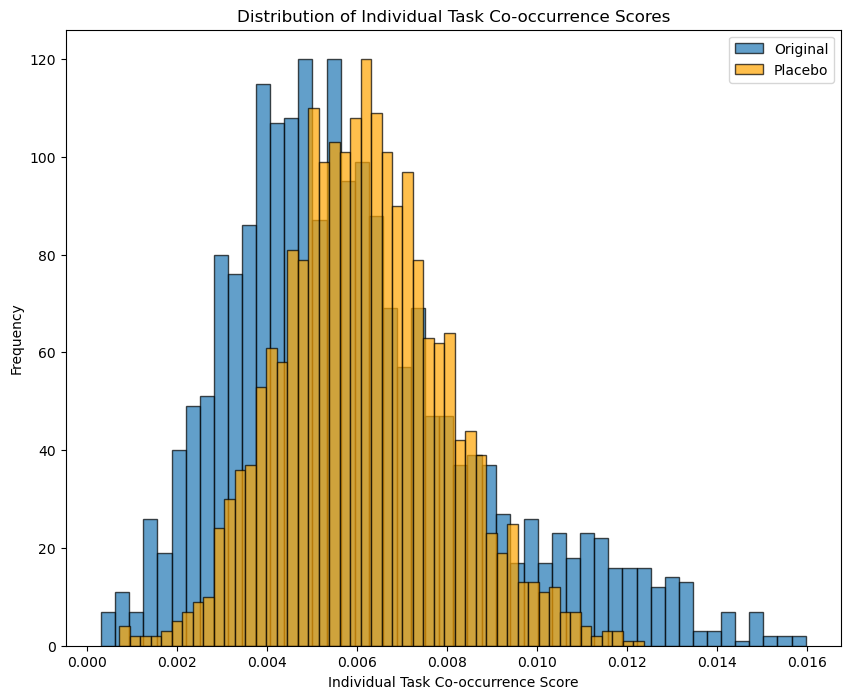

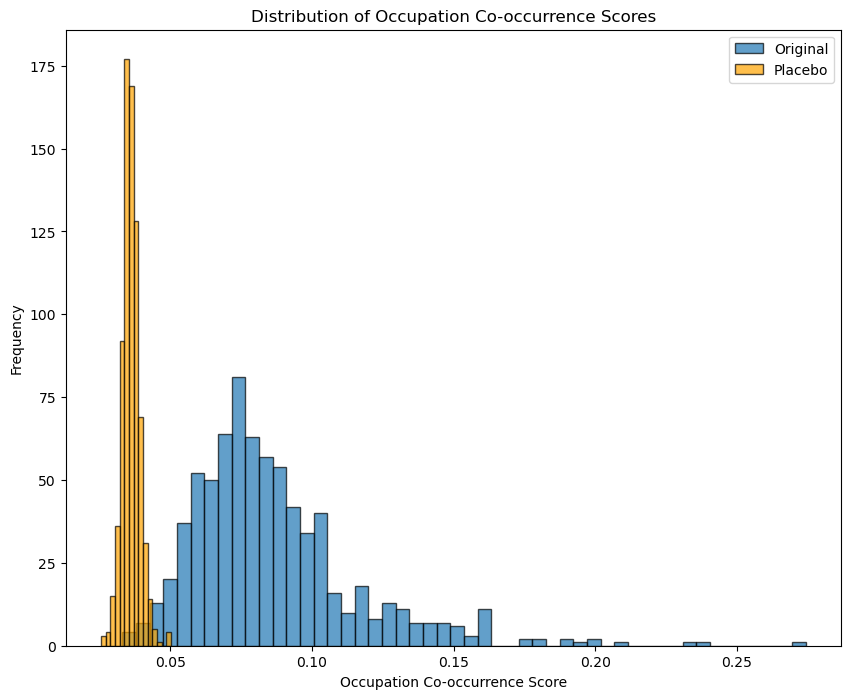

In [13]:
# Plot histogram of co-occurrence scores
# Task Scores
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(task_scores_df['cooccurrence_score'], bins=50, edgecolor='black', alpha=0.7, label='Original')
ax.hist(task_scores_df_random['cooccurrence_score'], bins=50, edgecolor='black', alpha=0.7, color='orange', label='Placebo')
ax.set_title('Distribution of Individual Task Co-occurrence Scores')
ax.set_xlabel('Individual Task Co-occurrence Score')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
plt.savefig(f'{output_plot_path}/indiv_task_cooccurrence_score_histogram.png', dpi=300)
plt.show()

# Occupation scores
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(occupation_scores_df['cooccurrence_score'], bins=50, edgecolor='black', alpha=0.7, label='Original')
ax.hist(occupation_scores_df_random['cooccurrence_score'], bins=15, edgecolor='black', alpha=0.7, color='orange', label='Placebo')
ax.set_title(f'Distribution of Occupation Co-occurrence Scores')
ax.set_xlabel('Occupation Co-occurrence Score')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
plt.savefig(f'{output_plot_path}/indiv_occupation_cooccurrence_score_histogram.png', dpi=300)
plt.show()

## Section 2

<br>

### Get non-weighted task pair repetition score

In [14]:
def count_task_pairs(df, occupation_variable, task_variable):
    # Ensure both columns are string-typed before sorting
    df[occupation_variable] = df[occupation_variable].astype(str)
    df[task_variable] = df[task_variable].astype(str)
    
    # Step 1: Sort (if desired) and build a mapping: occupation -> set of tasks
    # Sorting is optional here since sets ignore order, but kept for completeness
    df_sorted = df.sort_values(by=[occupation_variable, task_variable])
    occ_to_tasks = (
        df_sorted
        .groupby(occupation_variable)[task_variable]
        .apply(set)
        .to_dict()
    )

    # Step 2: Initialize a dictionary to count pairs
    pair_counts = defaultdict(int)

    # Step 3: For each occupation, find all pairs of tasks and increment the counter
    for occ, tasks in occ_to_tasks.items():
        # Get all unique combinations of 2 tasks within this occupation
        for t1, t2 in itertools.combinations(tasks, 2):
            # Sort or tuple them consistently if you want to avoid directionality
            pair = tuple(sorted((t1, t2)))
            pair_counts[pair] += 1

    # Step 4: Convert to a DataFrame
    pair_counts_df = pd.DataFrame([(t1, t2, count) for (t1, t2), count in pair_counts.items()],columns=['Task1', 'Task2', 'Count'])
    pair_counts_df = pair_counts_df.sort_values(by='Count', ascending=False)

    return pair_counts_df

def pair_counts_to_matrix(pair_counts):
    # Extract all unique tasks from the keys
    tasks = set()
    for (t1, t2) in pair_counts.keys():
        tasks.add(t1)
        tasks.add(t2)
    tasks = sorted(tasks)  # for a consistent ordering

    # Create an empty DataFrame
    matrix = pd.DataFrame(0, index=tasks, columns=tasks, dtype=int)

    # Fill the DataFrame with counts
    for (t1, t2), count in pair_counts.items():
        matrix.at[t1, t2] = count
        matrix.at[t2, t1] = count  # make it symmetric

    return matrix


# Count how many occupations each pair of tasks appears in
pair_counts_df = count_task_pairs(onet, occupation_variable, task_variable)
pair_counts_df_random = count_task_pairs(onet_random_tasks, occupation_variable, task_variable)

# Save to csv
pair_counts_df.to_csv(f'{output_data_path}/task_pair_counts.csv', index=False)

### Plot non-weighted task pair repetition score

Length of task pair counts: 107325
Length of task pair counts w/ >10 repeats: 588


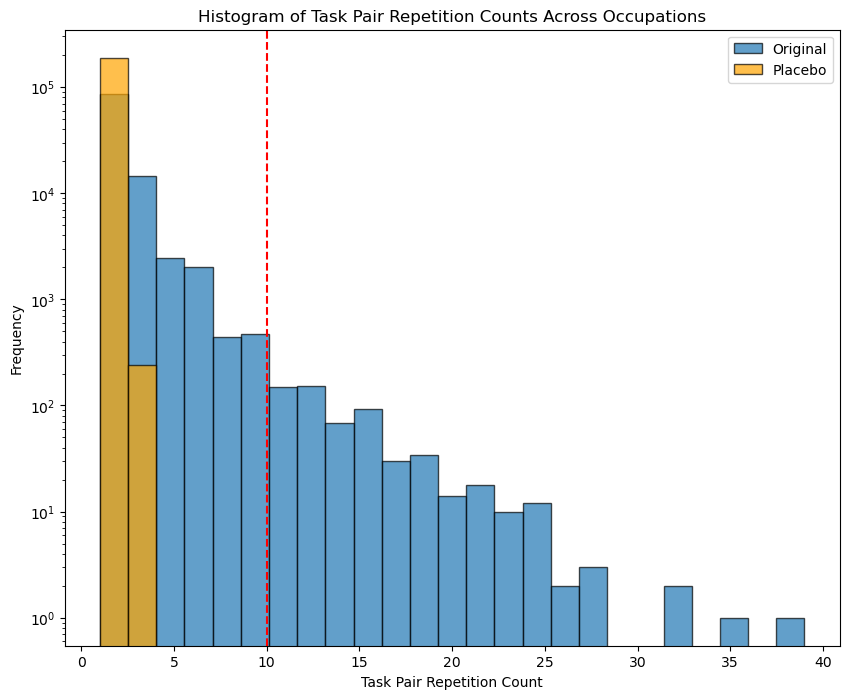

In [15]:
truncation_threhsold = 10
truncated_pair_counts = pair_counts_df[pair_counts_df.Count > truncation_threhsold]

n_bins = truncated_pair_counts.Count.max() - truncation_threhsold + 1

print(f'Length of task pair counts: {len(pair_counts_df)}')
print(f'Length of task pair counts w/ >{truncation_threhsold} repeats: {len(truncated_pair_counts)}')

# Plot task pair counts
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(pair_counts_df['Count'], bins=25, edgecolor='black', alpha=0.7, label='Original')
ax.hist(pair_counts_df_random['Count'], bins=2, edgecolor='black', alpha=0.7, label='Placebo', color='orange')
ax.set_yscale('log')  # Set y-axis to log scale
ax.set_title(f'Histogram of Task Pair Repetition Counts Across Occupations')# (for Pairs Appearing in >{truncation_threhsold} Occupations)')#\n\nCount of All Task Pairs: {len(pair_counts_df)}\nCount of Task Pairs Appearing in >{truncation_threhsold} Occupations: {len(truncated_pair_counts)}')
ax.set_xlabel('Task Pair Repetition Count')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
ax.axvline(x=truncation_threhsold, color='red', linestyle='--', label=f'x={truncation_threhsold}')  # Vertical line at x=5
plt.savefig(f'{output_plot_path}/task_pair_counts_histogram.png', dpi=300)
plt.show()

## Section 3

<br>

### Get Occupation Task Overlap (a.k.a. Occupation Similarity Score)

In [16]:
def create_occupation_similarity_matrix(onet, occupation_variable, task_variable):
    # 1. Create a mapping from occupation -> set of tasks
    occ_to_tasks = onet.groupby(occupation_variable)[task_variable].apply(set).to_dict()

    # 2. Gather all unique occupations
    all_occupations = list(occ_to_tasks.keys())

    # 3. Initialize a square DataFrame for the similarity matrix
    similarity_matrix = pd.DataFrame(
        0.0,
        index=all_occupations,
        columns=all_occupations
    )

    # 4. Compute ratio of (# common tasks) to (# unique tasks) for each pair of occupations
    for occ1 in all_occupations:
        tasks1 = occ_to_tasks[occ1]
        for occ2 in all_occupations:
            tasks2 = occ_to_tasks[occ2]

            common_tasks = tasks1.intersection(tasks2)
            all_unique_tasks = tasks1.union(tasks2)

            if len(all_unique_tasks) == 0:
                ratio = 0.0
            else:
                ratio = len(common_tasks) / len(all_unique_tasks)

            similarity_matrix.at[occ1, occ2] = ratio

    return similarity_matrix

# Generate the occupation similarity matrix
occupation_overlap_df = create_occupation_similarity_matrix(onet, occupation_variable, task_variable)
occupation_overlap_df_random = create_occupation_similarity_matrix(onet_random_tasks, occupation_variable, task_variable)

# Save the occupation overlap matrix to a CSV file
occupation_overlap_df.to_csv(f'{output_data_path}/occupation_similarity_matrix.csv', index=True)

In [17]:
def get_occupation_overlap_scores(occupation_overlap_df):
    # Create a list to store results
    results = []

    # Iterate over each row
    for i, row in occupation_overlap_df.iterrows():
        # Exclude the diagonal element by masking it
        row_values = row[row.index != i]  # Mask diagonal element
        avg_score = row_values.mean()
        results.append({'Occupation': i, 'Avg_Overlap_Score': avg_score})

    # Convert results to a DataFrame
    avg_occupation_overlap_scores_df = pd.DataFrame(results)
    avg_occupation_overlap_scores_df = avg_occupation_overlap_scores_df.sort_values(by='Avg_Overlap_Score', ascending=False).reset_index(drop=True)

    return avg_occupation_overlap_scores_df


# Get occupation overlap scores
avg_occupation_overlap_scores_df = get_occupation_overlap_scores(occupation_overlap_df)
avg_occupation_overlap_scores_df_random = get_occupation_overlap_scores(occupation_overlap_df_random)

# Save the resulting dataframe to a CSV file
avg_occupation_overlap_scores_df.to_csv(f'{output_data_path}/occupation_overlap_scores.csv', index=False)

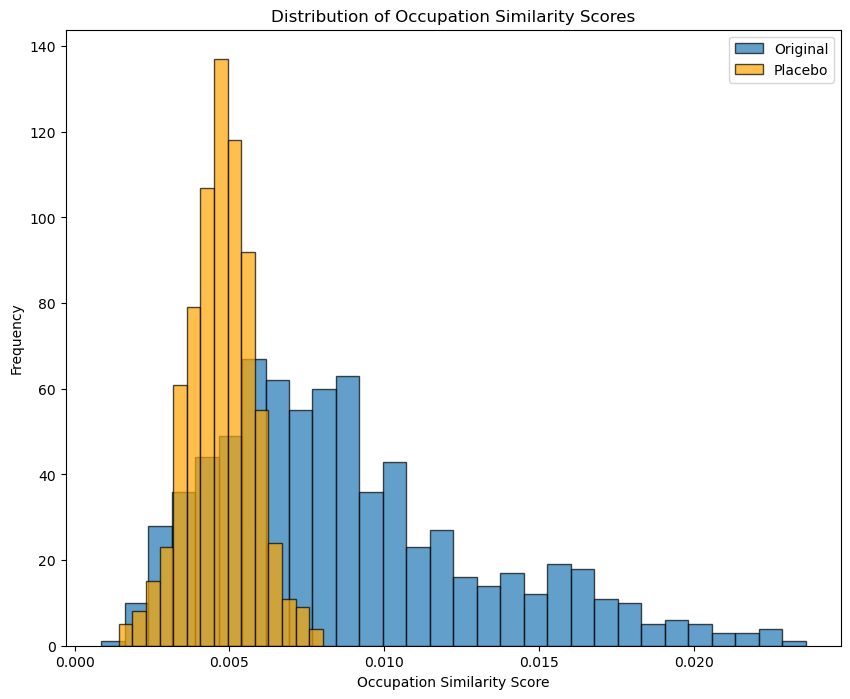

In [18]:
# Plot histogram of occupation overlap scores
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(avg_occupation_overlap_scores_df['Avg_Overlap_Score'], bins=30, edgecolor='black', alpha=0.7, label='Original')
ax.hist(avg_occupation_overlap_scores_df_random['Avg_Overlap_Score'], bins=15, edgecolor='black', alpha=0.7, label='Placebo', color='orange')
ax.set_title(f'Distribution of Occupation Similarity Scores')
ax.set_xlabel('Occupation Similarity Score')
ax.set_ylabel('Frequency')
ax.legend(loc='upper right')
plt.savefig(f'{output_plot_path}/occupation_similarity_score_histogram.png', dpi=300)
plt.show()

### Get occupation-similarity-weighted task pair repetition score

In [19]:
def weighted_task_pairs_count(df, occupation_overlap_df, occupation_variable, task_variable):
    """
    For each pair of tasks, this function:
      1) Gathers all occupations that have both tasks.
      2) Subsets occupation_overlap_df to those occupations (rows & columns).
      3) Inverts the submatrix and averages the off-diagonal entries in the upper triangle.
      4) Returns a DataFrame with columns:
         [Task1, Task2, Weighted_Score, Num_Occupations, Avg_Occupation_Task_Count, Occupations_List].
    """

    # 1. Build a mapping: occupation -> set of tasks
    occ_to_tasks = df.groupby(occupation_variable)[task_variable].apply(set).to_dict()

    # 2. For each pair of tasks, gather the occupations that have both
    pair_to_occupations = defaultdict(set)
    for occ, tasks in occ_to_tasks.items():
        for t1, t2 in itertools.combinations(tasks, 2):
            pair = tuple(sorted((t1, t2)))
            pair_to_occupations[pair].add(occ)

    results = []
    # 3. Process each pair to compute Weighted_Score & average task count for those occupations
    for (t1, t2), occs in pair_to_occupations.items():
        occs_list = list(occs)

        # -- Weighted_Score (average off-diagonal in the inverted submatrix)
        if len(occs_list) < 2:
            count_value = 0.0
        else:
            submatrix = occupation_overlap_df.loc[occs_list, occs_list].values
            inverted_submatrix = 1 / submatrix

            # Replace inf/-inf with 0 to avoid errors
            inverted_submatrix[np.isinf(inverted_submatrix)] = 0

            r, c = np.triu_indices(n=inverted_submatrix.shape[0], k=1)
            upper_tri_values = inverted_submatrix[r, c]
            count_value = np.mean(upper_tri_values)

        # -- Average number of tasks across these occupations
        if len(occs_list) > 0:
            avg_occ_task_count = np.mean([len(occ_to_tasks[o]) for o in occs_list])
        else:
            avg_occ_task_count = 0.0

        # 4. Append the row to results:
        #    (Task1, Task2, Weighted_Score, Num_Occupations, Avg_Occupation_Task_Count, Occupations_List)
        results.append((t1, t2, count_value, len(occs_list), avg_occ_task_count, occs_list))

    # 5. Create a DataFrame with the extended columns
    df_results = pd.DataFrame(results, columns=["Task1", "Task2", "Weighted_Count", "Num_Occupations", "Avg_Occupation_Task_Count", "Occupations_List"])
    df_results = df_results[df_results['Weighted_Count'] > 0]
    df_results = df_results.sort_values(by="Weighted_Count", ascending=False).reset_index(drop=True)

    return df_results


# Run function
weighted_pairs_df = weighted_task_pairs_count(onet, occupation_overlap_df, occupation_variable, task_variable, )
weighted_pairs_df_random = weighted_task_pairs_count(onet_random_tasks, occupation_overlap_df_random, occupation_variable, task_variable)

# Save the results
weighted_pairs_df.to_csv(f'{output_data_path}/task_pair_weightedScores.csv', index=False)

In [20]:
weighted_pairs_df

,Task1,Task2,Weighted_Count,Num_Occupations,Avg_Occupation_Task_Count,Occupations_List
0,Assign duties or work schedules to employees.,"Maintain records, documents, or other files.",75.50,2,76.50,"[Personal Service Managers, All Other, Compute..."
1,Discuss design or technical features of produc...,"Evaluate potential of products, technologies, ...",74.00,2,75.00,"[Sales Representatives, Wholesale and Manufact..."
2,Develop organizational policies or programs.,"Search files, databases or reference materials...",73.00,2,74.00,"[Computer Occupations, All Other, Secretaries ..."
3,Document operational activities.,Record images needed to address work issues.,70.00,2,71.00,"[Computer Occupations, All Other, Radio, Cellu..."
4,Prepare technical or operational reports.,Testify at legal or legislative proceedings.,69.50,2,70.50,"[Health and Safety Engineers, Except Mining Sa..."
...,...,...,...,...,...,...
41854,Inspect textile products.,Program equipment to perform production tasks.,1.22,2,20.00,"[Textile Knitting and Weaving Machine Setters,..."
41855,Apply adhesives to construction materials.,Load materials into construction equipment.,1.10,2,10.50,"[Insulation Workers, Mechanical, Insulation Wo..."
41856,Install insulation in equipment or structures.,Load materials into construction equipment.,1.10,2,10.50,"[Insulation Workers, Mechanical, Insulation Wo..."
41857,Load materials into construction equipment.,"Remove worn, damaged or outdated materials fro...",1.10,2,10.50,"[Insulation Workers, Mechanical, Insulation Wo..."


### Plot the best of both worlds: filter for number of occupations in weighted scores version

Length of task pair counts: 41859
Length of task pair counts w/ >10 repeats: 588


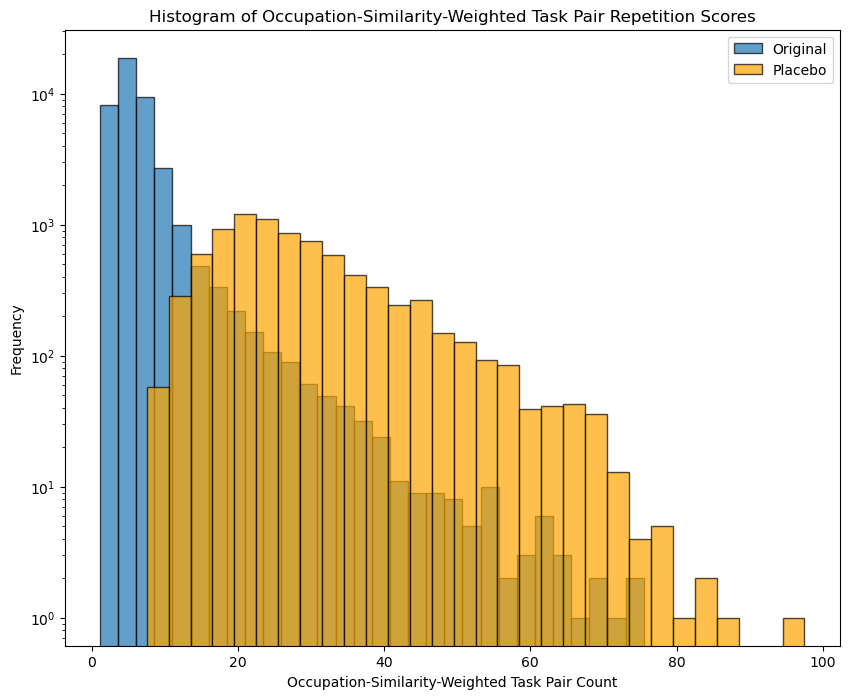

In [21]:
# Filter 1) by weighted count and 2) by number of occupations
# 1)
truncation_threhsold = 0
truncated_pair_counts = weighted_pairs_df[weighted_pairs_df.Weighted_Count > truncation_threhsold]

# 2)
num_occs_threshold = 10
truncated_pair_counts = truncated_pair_counts[truncated_pair_counts.Num_Occupations > num_occs_threshold]

# Save to output
truncated_pair_counts.to_csv(f'{output_data_path}/task_pair_weightedScores_truncated.csv', index=False)

# Print Stats
print(f'Length of task pair counts: {len(weighted_pairs_df)}')
print(f'Length of task pair counts w/ >{num_occs_threshold} repeats: {len(truncated_pair_counts)}')


# Plot weighted task pair count
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(weighted_pairs_df['Weighted_Count'], bins=30, edgecolor='black', alpha=0.7, label='Original')
ax.hist(weighted_pairs_df_random['Weighted_Count'], bins=30, edgecolor='black', alpha=0.7, label='Placebo', color='orange')
ax.set_title(f'Histogram of Occupation-Similarity-Weighted Task Pair Repetition Scores')#\nfor Task Pairs Appearing in >{num_occs_threshold} Occupations\n\nCount of All Task Pairs: {len(pair_counts_df)}\nCount of Task Pairs in >{num_occs_threshold} Occupations: {len(truncated_pair_counts)}')
ax.set_xlabel('Occupation-Similarity-Weighted Task Pair Count')
ax.set_ylabel('Frequency')
ax.set_yscale('log')  # Set y-axis to log scale
ax.legend(loc='upper right')
plt.savefig(f'{output_plot_path}/task_pair_weightedScore_histogram.png', dpi=300)
plt.show()